# 2D Poisson problem with TV denoising

### Imports

In [18]:
from cuqi.problem import BayesianProblem
from cuqi.distribution import Gaussian
from cuqi.experimental.mcmc import  ULA
from cuqi.samples import Samples
from cuqi.implicitprior import RestorationPrior, MoreauYoshidaPrior
from cuqipy_fenics.testproblem import FEniCSPoisson2D
import numpy as np
import cuqi
import cuqipy_fenics
import dolfin as dl
import matplotlib.pyplot as plt
from skimage.restoration import denoise_tv_chambolle
import os

# set logging level of dl
dl.set_log_level(dl.LogLevel.ERROR)

### Problem (infer log conductivity), w($\xi$), from measurements u($\xi$)



$$ \nabla \cdot \left( e^{w({\xi})} \nabla u(\xi)\right ) = f(\xi) \;\; \text{ in } \;\;\Omega = (0,1)^2 $$

### Print CUQIpy and CUQIpy-FEniCS versions:

In [19]:
print(cuqi.__version__)
print(cuqipy_fenics.__version__)

0+untagged.3985.gd684612.dirty
0+untagged.256.g7d0d1eb


### Parameters

In [20]:
np.random.seed(0)

Ns = 700
Nt= 2
Nb = 200 

noise_level = 0.01

TV_weight_factor = 10
nx = 32 #(for nx by nx mesh)
sample_batches = True

### Tag (used for file names, etc)

In [21]:
expr_tag = f"_nx_{nx}_rest_str_{TV_weight_factor}_Ns_{Ns}"
print(expr_tag)

_nx_32_rest_str_10_Ns_700


### Forward model

In [22]:
A = FEniCSPoisson2D(dim=(nx,nx), field_type=None, mapping='exponential', bc_types=['Dirichlet', 'Dirichlet', 'Dirichlet', 'Dirichlet']).model


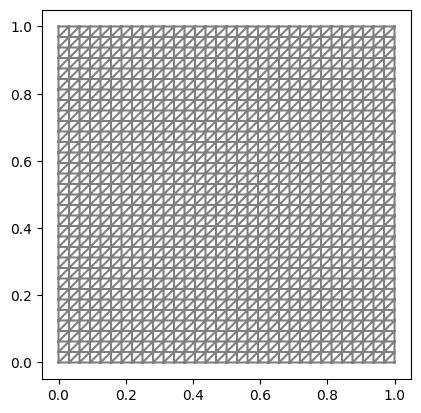

In [23]:
dl.plot(A.domain_geometry.mesh)

### Create true signal

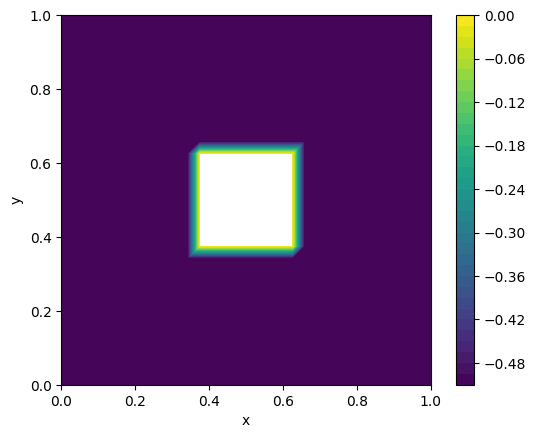

In [24]:
# set a 2D signal with a square in the middle
fun_x_true_expr = dl.Expression('(x[0]>0.35 && x[0]< 0.65 && x[1]>0.35 && x[1]< 0.65) ? 0 : -0.5', degree=1)
x_true_fun = dl.interpolate(fun_x_true_expr, A.domain_geometry.function_space)
x_true = cuqi.array.CUQIarray(x_true_fun.vector().get_local(), geometry=A.domain_geometry)

im = x_true.plot()
plt.colorbar(im[0])

### Compute noise STD

In [25]:

x_true.shape
y_true = A(x_true)
s_noise = 1.0/np.sqrt(A.domain_geometry.par_dim)* noise_level*np.linalg.norm(y_true)

### Create MoreauYoshidaPrior

In [26]:
restoration_strength = 0.5  * s_noise**2

def prox_g(x, restoration_strength=None):
    # x is dof of the function, create a function from the dof
    H_prox = A.domain_geometry.function_space
    x_fun = dl.Function(H_prox)
    x_fun.vector()[:] = x
    # convert to numpy array on a 2D grid
    vertices_on_axis = int(np.sqrt(A.domain_geometry.mesh.num_vertices()))
    x_grid = x_fun.compute_vertex_values().reshape((vertices_on_axis,vertices_on_axis)) 
    denoised_image = denoise_tv_chambolle(x_grid, weight=TV_weight_factor*restoration_strength, max_num_iter=100)
    
    # reorder denoised image to dof
    # TODO: we can call dl.dof_to_vertex_map once only for performance
    d2v = dl.dof_to_vertex_map(A.domain_geometry.function_space)
    return  denoised_image.flatten()[d2v], None   
    

# Now we can define our RestorationPrior.
restorator = RestorationPrior(
        prox_g,
        geometry=A.domain_geometry
    )
x = MoreauYoshidaPrior(restorator, smoothing_strength=restoration_strength)


### Create the data distribution and the data

In [27]:
y = Gaussian(A(x), s_noise**2, geometry=A.range_geometry)

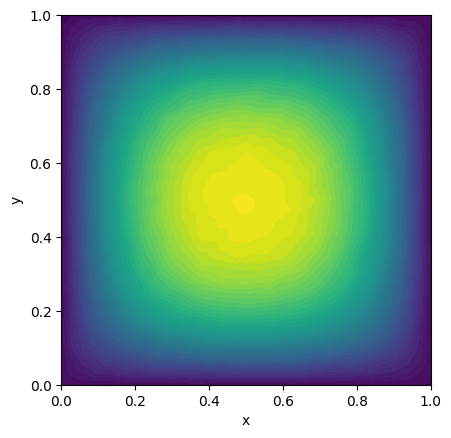

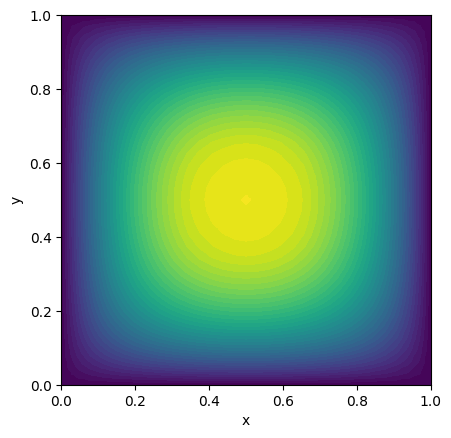

In [28]:
y_obs = y(x=x_true).sample()
y_obs.plot()
plt.figure()
y_true.plot()

### Create the Bayesian problem

In [29]:
# Set the random seed
np.random.seed(3) 

In [30]:
BP = BayesianProblem(y, x).set_data(y=y_obs)

### Sample the posterior

In [31]:
posterior = BP.posterior()
initial_point = np.ones(A.domain_geometry.par_dim)*-0.25
   
sampler = ULA(posterior, scale=1e-4, initial_point=initial_point)

#### Sample in batches if the number of samples is large

In [32]:
_ = sampler.warmup(Nb)
all_samples_list = []
all_samples_list.append(sampler.get_samples().samples)
sampler._samples = []
if sample_batches:
    N_batches = 10
    for batch_idx in range(N_batches):
        print(f'batch number {batch_idx} of {N_batches}')
        _ = sampler.sample(int(Ns/N_batches))
        samples_batch = sampler.get_samples()
        all_samples_list.append(samples_batch.burnthin(Nb=0, Nt=Nt).samples)
        #sampler.save_checkpoint('checkpoint_'+expr_tag+'.pickle')
        #sampler.reset()
        #sampler.load_checkpoint('checkpoint_'+expr_tag+'.pickle')
        sampler._samples = []

    all_samples_array = np.concatenate(all_samples_list, axis=1) #TODO 0 or 1
    posterior_samples_pre = cuqi.samples.Samples(all_samples_array, geometry=A.domain_geometry)    
    


else:
    _ = sampler.sample(Ns)
    posterior_samples_pre = sampler.get_samples()

Warmup: 100%|██████████| 200/200 [00:07<00:00, 26.49it/s, acc rate: 100.00%]


batch number 0 of 10


Sample: 100%|██████████| 70/70 [00:02<00:00, 25.54it/s, acc rate: 100.00%]


batch number 1 of 10


Sample: 100%|██████████| 70/70 [00:02<00:00, 25.92it/s, acc rate: 100.00%]


batch number 2 of 10


Sample: 100%|██████████| 70/70 [00:02<00:00, 26.29it/s, acc rate: 100.00%]


batch number 3 of 10


Sample: 100%|██████████| 70/70 [00:02<00:00, 27.33it/s, acc rate: 100.00%]


batch number 4 of 10


Sample: 100%|██████████| 70/70 [00:02<00:00, 30.07it/s, acc rate: 100.00%]


batch number 5 of 10


Sample: 100%|██████████| 70/70 [00:02<00:00, 30.12it/s, acc rate: 100.00%]


batch number 6 of 10


Sample: 100%|██████████| 70/70 [00:02<00:00, 25.65it/s, acc rate: 100.00%]


batch number 7 of 10


Sample: 100%|██████████| 70/70 [00:02<00:00, 27.36it/s, acc rate: 100.00%]


batch number 8 of 10


Sample: 100%|██████████| 70/70 [00:02<00:00, 26.85it/s, acc rate: 100.00%]


batch number 9 of 10


Sample: 100%|██████████| 70/70 [00:02<00:00, 26.37it/s, acc rate: 100.00%]


In [33]:
posterior_samples = posterior_samples_pre.burnthin(Nb)


### Plot results

In [34]:
# Read all the cases for reg strength 
dir = "../results_nov22/"
file_list = [
"posterior_samples_2D_nx_32_rest_str_1.0_Ns_500000.npz",
"posterior_samples_2D_nx_32_rest_str_5.0_Ns_500000.npz",
"posterior_samples_2D_nx_32_rest_str_7.0_Ns_500000.npz",
"posterior_samples_2D_nx_32_rest_str_10.0_Ns_500000.npz",
"posterior_samples_2D_nx_32_rest_str_20.0_Ns_500000.npz",
"posterior_samples_2D_nx_32_rest_str_30.0_Ns_500000.npz"]

rest_str_factor = [1.0, 5.0, 7.0, 10.0, 20.0, 30.0]

data_list = []

for file in file_list:
    data = np.load(dir+file)
    data_list.append(Samples(data['samples'], geometry=A.domain_geometry))

#posterior_samples_2D_nx_32_rest_str_50.0_Ns_500000.npz
#posterior_samples_2D_nx_32_rest_str_60.0_Ns_500000.npz

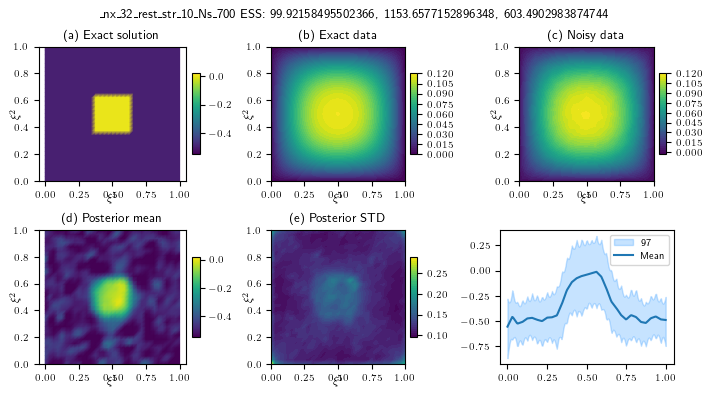

In [35]:

physical_dim = 2
posterior_samples = data_list[1]
if True:

    import os
    from matplotlib import ticker
    import matplotlib.pyplot as plt
    
    # Set up matplotlib
    SMALL_SIZE = 7
    MEDIUM_SIZE = 8
    BIGGER_SIZE = 9
    plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    # Use latex package
    plt.rc('text', usetex=True)
    plt.rc('text.latex', preamble=r'\usepackage{bm}')
    
    # Data directory
    fig_dir = './figs/'
    
    # Figure file
    fig_dir = fig_dir 
    
    # Check if the directory exists
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    
    # Figure version
    version = 'v8'
    
    # Figure file
    fig_file = fig_dir + 'paper_figure1_'+expr_tag+'_'+version+'.pdf'
    
    # Create the figure
    cm_to_in = 1/2.54
    fig, axs = plt.subplots(nrows=2, ncols=3,
                            figsize=(17.8*cm_to_in, 9.8*cm_to_in),
                            layout="constrained")
    
    # Define the colors to be used in the plots
    colors = ['C0', 'green', 'purple', 'k', 'gray']
    
    # (a)
    plt.sca(axs[0,0])
    
    
    if physical_dim == 2: 
        im = x_true.plot(subplots=False, vmin=-0.55, vmax=0.02, mode='color')
        inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
        fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
        plt.gca().set_ylim(0, 1)
    else:
        im = x_true.plot(subplots=False)
    
    #plt.gca().set_xlim(0, 1)
    plt.gca().set_title('(a) Exact solution')
    plt.ylabel('$\\xi^2$')
    plt.gca().yaxis.labelpad = -5
    plt.xlabel('$\\xi^1$')
    plt.gca().xaxis.labelpad = -5
    
    # (b)
    plt.sca(axs[0,1])
    im = y_true.plot(subplots=False)
    
    if physical_dim == 2:
        inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
        fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
        plt.ylabel('$\\xi^2$')
        plt.gca().yaxis.labelpad = -5
        plt.gca().set_title('(b) Exact data')
    else:
        samples_mean = cuqi.array.CUQIarray(posterior_samples.mean(), geometry=A.domain_geometry)
        A(samples_mean).plot(subplots=False)
        plt.gca().set_title('(b) Exact and predicted data')
    plt.xlabel('$\\xi^1$')
    plt.gca().xaxis.labelpad = -5
    
    
    # (c)
    plt.sca(axs[0,2])
    im = y_obs.plot(subplots=False)
    if physical_dim == 2:
        inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
        fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
        plt.ylabel('$\\xi^2$')
        plt.gca().yaxis.labelpad = -5
    plt.xlabel('$\\xi^1$')
    plt.gca().xaxis.labelpad = -5
    plt.gca().set_title('(c) Noisy data')
    
    # (d)
    plt.sca(axs[1,0])

    if physical_dim == 2:
        im = posterior_samples.plot_mean(
            subplots=False, vmin=-0.55, vmax=0.02, mode='color')
        inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
        fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
        plt.gca().set_ylim(0, 1)
        plt.ylabel('$\\xi^2$')
        plt.gca().yaxis.labelpad = -5
    else:
        im = posterior_samples.plot_mean(subplots=False)
    
    #plt.gca().set_xlim(0, 1)
    plt.xlabel('$\\xi^1$')
    plt.gca().xaxis.labelpad = -5
    plt.gca().set_title('(d) Posterior mean')
    
    # (e)
    plt.sca(axs[1,1])
    im = posterior_samples.funvals.vector.plot_std(subplots=False)
    
    if physical_dim == 2:
        inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
        cb = fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
        cb.locator = ticker.MaxNLocator(nbins=4)
        plt.ylabel('$\\xi^2$')
        plt.gca().yaxis.labelpad = -5
    plt.xlabel('$\\xi^1$')
    plt.gca().xaxis.labelpad = -5
    plt.gca().set_title('(e) Posterior STD')
    
    # (f)
    plt.sca(axs[1,2])
    
    # extract values of samples at line \xi_2  = 0.5
    line_samples = []
    xi_1 = np.linspace(0, 1, 200)
    samples_funvals = posterior_samples.funvals
    for i, fun_i in enumerate(samples_funvals):
        temp_list = []
        for xi_1_i in xi_1:
            temp_list.append(fun_i(xi_1_i, 0.5))
        line_samples.append(temp_list)
    line_samples = np.array(line_samples)
    line_samples_obj = cuqi.samples.Samples(line_samples.T, geometry=cuqi.geometry.Continuous1D(xi_1))
    line_samples_obj.plot_ci( 97)

  #  lci = posterior_samples.plot_ci(
  #      97, exact=x_true, plot_par=True, markersize=SMALL_SIZE-3)
  #  lci[0].set_label("Mean")
  #  lci[1].set_label("Exact")
  #  lci[2].set_label("$97\\%$ CI")
  #  #plt.ylim(-5, 3)
  #  plt.legend(ncols=2) 
  #  plt.ylabel(r'$\bm{x}_i$')
  #  plt.gca().yaxis.labelpad = -5
  #  plt.gca().yaxis.set_label_coords( -0.06, 0.5)
  #  plt.xlabel('$i$')
  #  plt.gca().xaxis.labelpad = -5
  #  plt.gca().set_title('(f) Posterior CI')
  #  n_ticks = 8
  #  num_var = posterior_samples.geometry.par_dim
  #  tick_ids = np.linspace(0, num_var-1, n_ticks, dtype=int)
  #  plt.xticks(tick_ids, tick_ids)
  #  # switch legend off
  #  plt.gca().legend().set_visible(False)

    ess_list = posterior_samples.compute_ess()
    plt.suptitle(expr_tag+' ESS: '+str(np.min(ess_list))+', '+str(np.max(ess_list))+', '+str(np.mean(ess_list)))
    # Save the figure
    plt.savefig(fig_file, bbox_inches='tight', pad_inches=0.01, dpi=1200)

### Plot CI in a different order

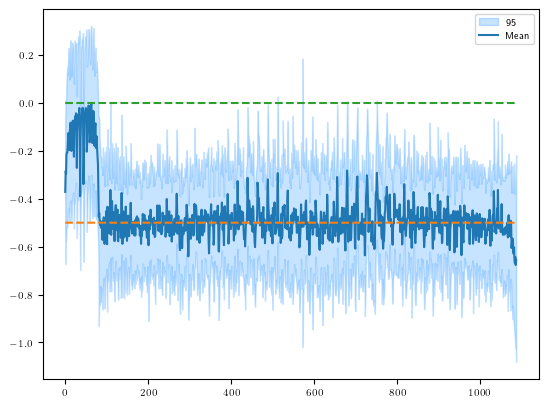

In [36]:
# from exact solution extract indices of the square

indices_of_square = np.where(x_true.to_numpy() > -0.2)[0]

reordered_samples = np.zeros_like(posterior_samples.samples)
reordered_samples[ :len(indices_of_square), :] = posterior_samples.samples[ indices_of_square, :]
reordered_samples[ len(indices_of_square):, :] = posterior_samples.samples[ np.setdiff1d(np.arange(A.domain_geometry.par_dim), indices_of_square), :]

reordered_CUQI_samples = cuqi.samples.Samples(reordered_samples)

reordered_CUQI_samples.plot_ci()
plt.plot(np.ones(A.domain_geometry.par_dim)*-0.5, '--')
plt.plot(np.ones(A.domain_geometry.par_dim)*0, '--')

### denoise_tv_chambolle illustration

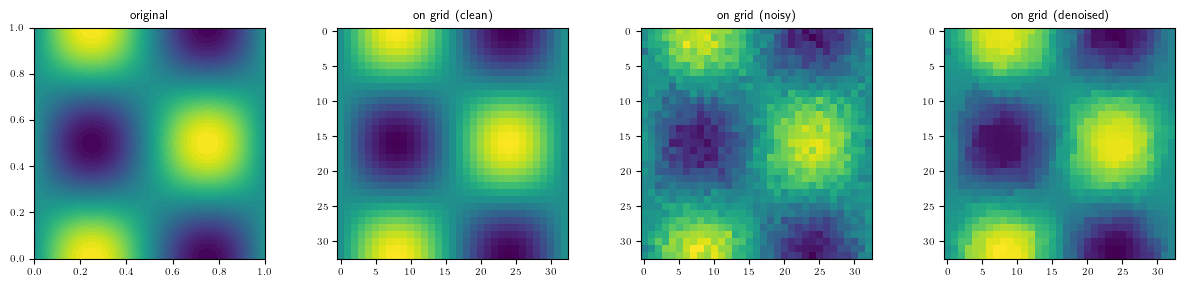

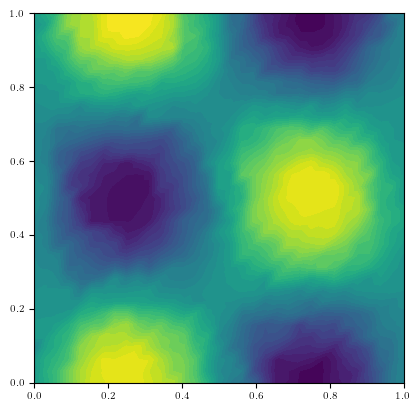

In [37]:
# create a plot with one row and 4 columns
fig, axs = plt.subplots(1, 4, figsize=(15, 3))

plt.sca(axs[0])
# sin cos fenics expression
f_expr_sin_cos = dl.Expression('sin(2*pi*x[0])*cos(2*pi*x[1])', degree=2)
f_sin_cos = dl.interpolate(f_expr_sin_cos, A.domain_geometry.function_space)
dl.plot(f_sin_cos)
plt.title('original')

plt.sca(axs[1])
x_grid = f_sin_cos.compute_vertex_values().reshape((nx+1,nx+1))
plt.imshow(x_grid)
plt.title('on grid (clean)')

# add noise to x_grid
x_grid += np.random.normal(0, 0.1, x_grid.shape)
plt.sca(axs[2])
plt.imshow(x_grid)
plt.title('on grid (noisy)')

x_grid_tv = denoise_tv_chambolle(x_grid, weight=0.1, max_num_iter=100)
plt.sca(axs[3])
plt.imshow(x_grid_tv)
plt.title('on grid (denoised)')

# go back from x_grid to fenics function
fun_from_x_grid = dl.Function(A.domain_geometry.function_space)

#TODO: why d2v not v2d?
plt.figure()
v2d = dl.vertex_to_dof_map(A.domain_geometry.function_space)
d2v = dl.dof_to_vertex_map(A.domain_geometry.function_space)
fun_from_x_grid.vector()[:] = x_grid_tv.flatten()[d2v]
dl.plot(fun_from_x_grid)

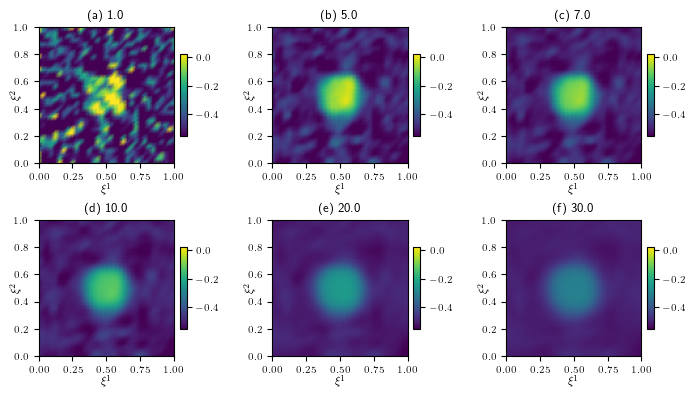

In [38]:

physical_dim = 2
if True:

    import os
    from matplotlib import ticker
    import matplotlib.pyplot as plt
    
    # Set up matplotlib
    SMALL_SIZE = 7
    MEDIUM_SIZE = 8
    BIGGER_SIZE = 9
    plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    # Use latex package
    plt.rc('text', usetex=True)
    plt.rc('text.latex', preamble=r'\usepackage{bm}')
    
    # Data directory
    fig_dir = './figs/'
    
    # Figure file
    fig_dir = fig_dir 
    
    # Check if the directory exists
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    
    # Figure version
    version = 'v8'
    
    # Figure file
    fig_file = fig_dir + 'paper_figure2_'+version+'.pdf'
    
    # Create the figure
    cm_to_in = 1/2.54
    fig, axs = plt.subplots(nrows=2, ncols=3,
                            figsize=(17.8*cm_to_in, 9.8*cm_to_in),
                            layout="constrained")
    
    # Define the colors to be used in the plots
    colors = ['C0', 'green', 'purple', 'k', 'gray']
    
    # (a)
    plt.sca(axs[0,0])
    


    if physical_dim == 2:
        im = data_list[0].plot_mean(
            subplots=False, vmin=-0.55, vmax=0.02, mode='color')
        inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
        fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
        plt.gca().set_ylim(0, 1)
        plt.ylabel('$\\xi^2$')
        plt.gca().yaxis.labelpad = -5
    else:
        im = posterior_samples.plot_mean(subplots=False)
    
    plt.gca().set_xlim(0, 1)
    plt.xlabel('$\\xi^1$')
    plt.gca().xaxis.labelpad = 1
    plt.gca().set_title('(a) '+str(rest_str_factor[0]))
    
    # (b)
    plt.sca(axs[0,1])


    if physical_dim == 2:
        im = data_list[1].plot_mean(
            subplots=False, vmin=-0.55, vmax=0.02, mode='color')
        inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
        fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
        plt.gca().set_ylim(0, 1)
        plt.ylabel('$\\xi^2$')
        plt.gca().yaxis.labelpad = -5
    else:
        im = posterior_samples.plot_mean(subplots=False)
    
    plt.gca().set_xlim(0, 1)
    plt.xlabel('$\\xi^1$')
    plt.gca().xaxis.labelpad = 1
    plt.gca().set_title('(b) '+str(rest_str_factor[1]))
    
    
    # (c)
    plt.sca(axs[0,2])


    if physical_dim == 2:
        im = data_list[2].plot_mean(
            subplots=False, vmin=-0.55, vmax=0.02, mode='color')
        inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
        fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
        plt.gca().set_ylim(0, 1)
        plt.ylabel('$\\xi^2$')
        plt.gca().yaxis.labelpad = -5
    else:
        im = posterior_samples.plot_mean(subplots=False)
    
    plt.gca().set_xlim(0, 1)
    plt.xlabel('$\\xi^1$')
    plt.gca().xaxis.labelpad = 1
    plt.gca().set_title('(c) '+str(rest_str_factor[2]))
    
    # (d)
    plt.sca(axs[1,0])

    if physical_dim == 2:
        im = data_list[3].plot_mean(
            subplots=False, vmin=-0.55, vmax=0.02, mode='color')
        inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
        fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
        plt.gca().set_ylim(0, 1)
        plt.ylabel('$\\xi^2$')
        plt.gca().yaxis.labelpad = -5
    else:
        im = posterior_samples.plot_mean(subplots=False)
    
    plt.gca().set_xlim(0, 1)
    plt.xlabel('$\\xi^1$')
    plt.gca().xaxis.labelpad = 1
    plt.gca().set_title('(d) '+str(rest_str_factor[3]))
    
    # (e)
    plt.sca(axs[1,1])

    if physical_dim == 2:
        im = data_list[4].plot_mean(
            subplots=False, vmin=-0.55, vmax=0.02, mode='color')
        inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
        fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
        plt.gca().set_ylim(0, 1)
        plt.ylabel('$\\xi^2$')
        plt.gca().yaxis.labelpad = -5
    else:
        im = posterior_samples.plot_mean(subplots=False)
    
    plt.gca().set_xlim(0, 1)
    plt.xlabel('$\\xi^1$')
    plt.gca().xaxis.labelpad = 1
    plt.gca().set_title('(e) '+str(rest_str_factor[4]))
    
    # (f)
    plt.sca(axs[1,2])

    if physical_dim == 2:
        im = data_list[5].plot_mean(
            subplots=False, vmin=-0.55, vmax=0.02, mode='color')
        inset_axes = plt.gca().inset_axes([1.04, 0.2, 0.05, 0.6])
        fig.colorbar(im[0], ax=plt.gca(), cax=inset_axes)
        plt.gca().set_ylim(0, 1)
        plt.ylabel('$\\xi^2$')
        plt.gca().yaxis.labelpad = -5
    else:
        im = posterior_samples.plot_mean(subplots=False)
    
    plt.gca().set_xlim(0, 1)
    plt.xlabel('$\\xi^1$')
    plt.gca().xaxis.labelpad = 1
    plt.gca().set_title('(f) '+str(rest_str_factor[5]))


    # Save the figure
    plt.savefig(fig_file, bbox_inches='tight', pad_inches=0.01, dpi=1200)